## **Original sources**

* [Venelin Valkov - Get SH*T Done with PyTorch 121-150p](https://leanpub.com/getting-things-done-with-pytorch)
* [Keita Kurita - Paper Dissected: “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding” Explained](http://mlexplained.com/2019/01/07/paper-dissected-bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding-explained/)

* Preprocess tweets for [BERT](https://arxiv.org/abs/1810.04805) and build PyTorch Dataset
  * Tokenization
  * Attention mask
  * Padding
* Transfer Learning using Transformers from Hugging Face
* Model evaluation
* Sentiment prediction for raw text

## **Excerpts**
* BERT randomly masks words in the sentence and predicts them

<img src="https://camo.githubusercontent.com/4987646e620566ad6d4c266b4a7ea39ec71ae79a/68747470733a2f2f69302e77702e636f6d2f6d6c6578706c61696e65642e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031392f30312f53637265656e2d53686f742d323031392d30312d30332d61742d342e34302e32322d504d2e706e673f726573697a653d31303234253243323037" height="" width="641.5">

* The input schema for BERT is summarized below:

<img src="https://camo.githubusercontent.com/dfb8bd6f34135da45cc70b42f0ff3b00fb61afa4/68747470733a2f2f69312e77702e636f6d2f6d6c6578706c61696e65642e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031392f30312f53637265656e2d53686f742d323031392d30312d30342d61742d332e33322e34382d504d2e706e673f726573697a653d31303234253243333039" height="" width="641.5">

* BERT use the Transformer instead of the LSTM, a network with no recurrence that uses attention.


## **Setup**

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [0]:
# -qq hides part of installation output 
!pip install -qq transformers

     |████████████████████████████████| 665kB 5.0MB/s 
     |████████████████████████████████| 3.8MB 23.7MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
     |████████████████████████████████| 1.1MB 50.5MB/s 


In [0]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

## **EDA**

* Missing values
* Imbalance

In [0]:
df = pd.read_csv("train.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### **Missing values**

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [0]:
# Drop single empty row
df = df.dropna(how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### **Imbalance**

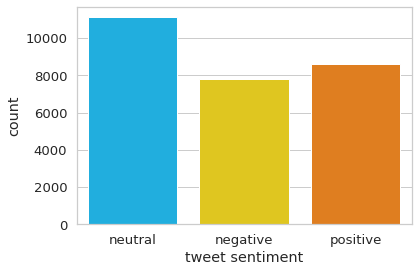

In [0]:
# Seaborn customizations
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 6, 4

# Ploting value counts in dataset
sns.countplot(df.sentiment)
plt.xlabel('tweet sentiment');

## **Preprocessing**

* Convert text to numbers

- Add special tokens to start sequence <code>[CLS]</code> (classification) and separate sentences <code>[SEP]</code>
- Pass sequences of constant length by padding <code>[PAD]</code>
- Create array of 0s (pad token) and 1s (real token) called <code>*attention mask*</code>

<code>Transformers</code> library includes prebuild tokenizers that do the heavy lifting for us.

### **Create integer representations for labels**

In [0]:
def to_sentiment(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else:
    return 2

df['sentiment_score'] = df.sentiment.apply(to_sentiment)

In [0]:
# Double-check
print(f"Negative {len(df[df['sentiment_score'] == 0]), len(df[df['sentiment'] == 'negative'])}")
print(f"Neutral {len(df[df['sentiment_score'] == 1]), len(df[df['sentiment'] == 'neutral'])}")
print(f"Positive {len(df[df['sentiment_score'] == 2]), len(df[df['sentiment'] == 'positive'])}")

Negative (7781, 7781)
Neutral (11117, 11117)
Positive (8582, 8582)


In [0]:
class_names = ['negative', 'neutral', 'positive']

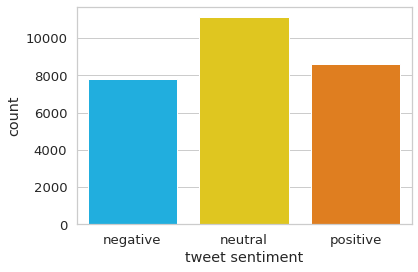

In [0]:
ax = sns.countplot(df.sentiment_score)
plt.xlabel('tweet sentiment')
ax.set_xticklabels(class_names);

### **Tokenization**

* There is cased and uncased version of BERT and tokenizer. The cased version works better. 
* E.g. "BAD" might convey more sentiment than "bad".

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [0]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### **Tokenization process**
Understanding step by step using single tweet's text

In [0]:
# Taking sample tweet from train dateset
sample_txt = df['text'][4]
sample_txt

' Sons of ****, why couldn`t they put them on the releases we already bought'

In [0]:
# Convert the text to tokens and tokens to unique integers (ids)
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'    Tweet: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

    Tweet:  Sons of ****, why couldn`t they put them on the releases we already bought
   Tokens: ['Sons', 'of', '*', '*', '*', '*', ',', 'why', 'couldn', '`', 't', 'they', 'put', 'them', 'on', 'the', 'releases', 'we', 'already', 'bought']
Token IDs: [9946, 1104, 115, 115, 115, 115, 117, 1725, 1577, 169, 189, 1152, 1508, 1172, 1113, 1103, 6596, 1195, 1640, 3306]


##### **Special Tokens**

`[SEP]` - marker for ending of a sentence


In [0]:
# Separate sentences in a single tweet
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - BERT encoder produces a sequence of hidden states. For classification tasks, this sequence ultimately needs to be reduced to a single vector. There are multiple ways of converting this sequence to a single vector representation of a sentence. One is max/mean pooling. Another is applying attention. The BERT authors, however, opt to go with a much simpler method: simply taking the hidden state corresponding to the first token.

To make this pooling scheme work, BERT prepends a [CLS] token (short for "classification") to the start of each sentence (this is essentially like a start-of-sentence token).

In [0]:
# Token for start of tweet
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Sequeces has to be in the same lenght, therefore some of them will have padding which is made by adding <code>[PAD]</code> to the empty sequence indices:

In [0]:
# Add padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [0]:
# Tokenize uknown words/symbols
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Above steps can be achieved using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [0]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [0]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 9946, 1104,  115,  115,  115,  115,  117, 1725, 1577,  169,  189,
        1152, 1508, 1172, 1113, 1103, 6596, 1195, 1640, 3306,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [0]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [0]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Sons',
 'of',
 '*',
 '*',
 '*',
 '*',
 ',',
 'why',
 'couldn',
 '`',
 't',
 'they',
 'put',
 'them',
 'on',
 'the',
 'releases',
 'we',
 'already',
 'bought',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

##### **Choosing Sequence Length**
BERT works with fixed-length sequences. We'll define the max length. First, store the token length of each tweet:

In [0]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

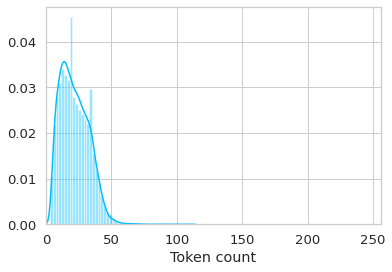

In [0]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
import statistics
print(f'Max token lenght: {max(token_lens)}')
print(f'Min token lenght: {min(token_lens)}')
print(f'Mode token lenght: {statistics.mode(token_lens)}')
print(f'Median token lenght: {statistics.median(token_lens)}')

Max token lenght: 110
Min token lenght: 3
Mode token lenght: 13
Median token lenght: 20.0


Tweets do not exceed 110 tokens and thus we choose a maximum length of 160.

In [0]:
MAX_LEN = 110

#### **PyTorch dataset**
We have all building blocks required to create a PyTorch dataset. Let's do it:

In [0]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

##### **Train val split**

The tokenizer is doing most of the heavy lifting for us. We also return the tweet texts, so it'll be easier to evaluate the predictions from our model. Now split the data:

In [0]:
# Split train.csv to df_train and df_val (10%) and load df_test from test.csv
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_test = pd.read_csv("test.csv")

# Add sentiment_score to test set
df_test['sentiment_score'] = df_test.sentiment.apply(to_sentiment)

In [0]:
df_train.shape, df_val.shape, df_test.shape

((24732, 5), (2748, 5), (3534, 4))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(), # text column
    targets=df.sentiment_score.to_numpy(), # sentiment_score column
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [0]:
# Bug was with str type of sentiment when not converting to sentiment_score
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [0]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 110])
torch.Size([16, 110])
torch.Size([16])


## **Sentiment Classification with BERT and Hugging Face**

* There are a lot of helpers that make using BERT easy with the Transformers library. 
* Depending on the task [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else might apply. 
* Here we'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build sentiment classifier on top of it.

Load the model:

In [0]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Trying it on the encoding of our sample text:

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [0]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [0]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Let's look at the shape of the output:

In [0]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [0]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [0]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 110])
torch.Size([16, 110])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [0]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4147, 0.1954, 0.3900],
        [0.4900, 0.1551, 0.3549],
        [0.2398, 0.1244, 0.6359],
        [0.5456, 0.1305, 0.3239],
        [0.5923, 0.1727, 0.2350],
        [0.3322, 0.1823, 0.4855],
        [0.4027, 0.1359, 0.4614],
        [0.3137, 0.2610, 0.4253],
        [0.3377, 0.1509, 0.5114],
        [0.2736, 0.2033, 0.5231],
        [0.4102, 0.1621, 0.4277],
        [0.4210, 0.1887, 0.3903],
        [0.5541, 0.0913, 0.3546],
        [0.4733, 0.1440, 0.3827],
        [0.4146, 0.1716, 0.4139],
        [0.3465, 0.1996, 0.4539]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### **Training**

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [0]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some [recommendations](http://mlexplained.com/2019/01/07/paper-dissected-bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding-explained/) for fine-tuning:

* Dropout: 0.1
* Batch size: 32, 16
* Optimizer: Adam
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 3, 4

For pretraining, BERT uses the following hyperparameters:

Sequence length (single example): 256

* Batch size: 512
* Training steps: 1,000,000 (Approximately 40 epochs)
* Optimizer: Adam
* Learning rate: 1e-4
* Learning rate schedule: Warmup for 10,000 steps, then linear decay
* Dropout: 0.1
* Activation function: gelu (Gaussian Error Linear Unit)
* The training took 4 days on 16 cloud TPUs (64 TPU chips).

Stick with the rest except for epochs for illustration purposes. Increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Continue with writing a helper function for training our model for one epoch:

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps evaluate the model on a given data loader:

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [0]:
# 10 epochs on tweets dataset took:
# CPU times: user 1h 46min 57s, sys: 55min 9s, total: 2h 42min 6s
# Wall time: 2h 42min 53s
# ~around 16 mins per epoch on K80 GPU
# Reducing to 3
EPOCHS = 3
# Tesla P100 runs more than x3 faster
# 3 epochs on Tesla P100:
# CPU times: user 10min 23s, sys: 4min 8s, total: 14min 31s
# Wall time: 14min 39s
# ~around 5 mins per epoch on Tesla P100 GPU

In [0]:
!nvidia-smi

Fri May 29 21:18:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   2653MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%%time
# 3 EPOCHS

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5579728778273368 accuracy 0.7777777777777778
Val   loss 0.5214847913661669 accuracy 0.7893013100436682

Epoch 2/3
----------
Train loss 0.4058819657136213 accuracy 0.8487384764677341
Val   loss 0.5369568246654993 accuracy 0.7925764192139738

Epoch 3/3
----------
Train loss 0.29002197849941364 accuracy 0.9063561377971858
Val   loss 0.7242444612865531 accuracy 0.7842066957787482

CPU times: user 10min 23s, sys: 4min 8s, total: 14min 31s
Wall time: 14min 39s


We're storing the state of the best model, indicated by the **highest validation** accuracy.

Training vs validation accuracy:

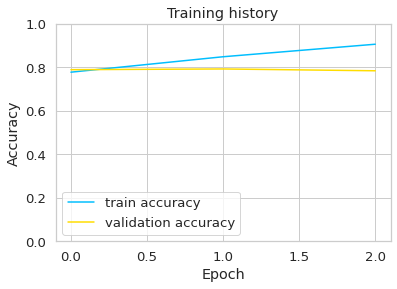

In [0]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

##### **Train attempt with 1 epoch**

In [0]:
%%time
# 1 EPOCH
EPOCHS = 1

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------
Train loss 0.21018199799377543 accuracy 0.9411289018275918
Val   loss 0.9443202473353162 accuracy 0.7856622998544396

CPU times: user 3min 26s, sys: 1min 23s, total: 4min 49s
Wall time: 4min 52s


## **Evaluation**

Calculate the accuracy on the test set:

In [0]:
# 3 EPOCHS
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.769100169779287

In [0]:
# 1 EPOCH
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7724957555178269

Models accuracy on validation set is 1.3% off the test set. Model seems to generalize well.

Define a helper function to get the predictions from model:

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the tweets and the predicted probabilities (by applying the softmax on the model outputs):

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

The classification report:

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.75      0.79      0.77      1001
     neutral       0.74      0.74      0.74      1430
    positive       0.83      0.79      0.81      1103

    accuracy                           0.77      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.77      0.77      0.77      3534



Examples for classification report:
* Recall = correctly predicted neutral / true number of neutral (incl. misclassified as negative or positive)

Continue with the confusion matrix:

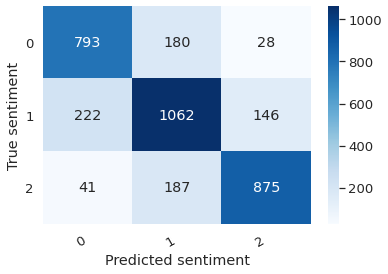

In [0]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(cm)

* Model misclassifies 26% of neutral tweets mostly confusing those with negative
* Misclassifying of positives as negatives and vice versa is very rare

Let's have a look at an example from our test data:

In [0]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [0]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Recession hit Veronique Branquinho, she has to quit her company, such
a shame!

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

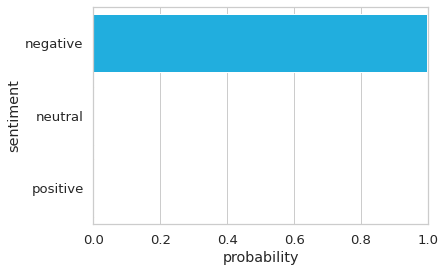

In [0]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### **Predicting on Raw Text**

See how model predicts the sentiment of some raw text:

In [0]:
review_text = "Sons of ****, why couldn`t they put them on the releases we already bought"

Use the tokenizer to encode the text:

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [0]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Sons of ****, why couldn`t they put them on the releases we already bought
Sentiment  : negative


## **End notes**

* This notebook is coming from tutorial in Venelin's Valkov's book  [Getting Things Done with Pytorch](https://leanpub.com/getting-things-done-with-pytorch)
* It is adopted to Kaggle's [Twitter Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) competition data set as a part of course work in deep learning
* Further steps could be extracting the tokens which mostly contributed to the sentiment prediction based on:
* Extract token importance
  * [Interpreting BERT Models (Part 1)](https://captum.ai/tutorials/Bert_SQUAD_Interpret)
  * [Unsupervised Text Selection - PyTorch Version](https://www.kaggle.com/rohitsingh9990/unsupervised-text-selection-pytorch-version)
  * [HTML text segment visualization](https://www.kaggle.com/jeinsong/html-text-segment-visualization)
  * [Unsupervised Text Selection](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143094)
* Submit neutrals in full text and most important strings for negative and positive tweets
* Train on full data set for better accuracy
* Train on BERTlarge instead of BERTbase
